In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,model_from_json,Model
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from tensorflow.keras.layers import Dense,Dropout,Flatten,Concatenate,Input
from tensorflow.keras.optimizers import SGD

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
import datetime
import os, sys
import shutil
import pathlib
import tempfile
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot,plot_model

### Data Preprocessing

In [3]:
# number of locations
n_train = 441
n_test = 70
n_valid = 63

img_train_path = "final data"
train_coords = read_csv(img_train_path + "/Coordinates.csv").values

img_test_path = "final test data"
test_coords = read_csv(img_test_path + "/Coordinates.csv").values

img_valid_path = "final validation data"
valid_coords = read_csv(img_valid_path + "/Coordinates.csv").values

In [4]:
def preprocess_images(n_images,img_path):
    img_list = []
    for i in range(n_images):
        loc = []
        for j in range(4):
            img = plt.imread(img_path+"/{}.jpg".format(i*4+j))
            
            # Scale to [0,1]
            if (img.dtype == np.uint8):
                img = img.astype(float) / 256
                
            # resize from (360, 640, 3) to (180, 320, 3)
            img = cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0]/2)),
                            interpolation=cv2.INTER_CUBIC)

            loc.append(img)

        loc = np.array(loc)
        img_list.append(loc)

    return np.array(img_list)

In [5]:
def seperate_four_directions(img_list):
    N = img_list[:,0,:]
    S = img_list[:,1,:]
    E = img_list[:,2,:]
    W = img_list[:,3,:]
    return N,S,E,W

In [6]:
# train data
img_train_list = preprocess_images(n_train,img_train_path)
N_train,S_train,E_train,W_train = seperate_four_directions(img_train_list)

In [7]:
img_train_list.shape

(441, 4, 180, 320, 3)

In [8]:
# test data
img_test_list = preprocess_images(n_test,img_test_path)
N_test,S_test,E_test,W_test = seperate_four_directions(img_test_list)

In [9]:
img_test_list.shape

(70, 4, 180, 320, 3)

In [10]:
# validation data
img_valid_list = preprocess_images(n_valid,img_valid_path)
N_valid,S_valid,E_valid,W_valid = seperate_four_directions(img_valid_list)

In [11]:
img_valid_list.shape

(63, 4, 180, 320, 3)

In [12]:
# image size
img_shape = N_train[0].shape
img_shape

(180, 320, 3)

### Four Directions VGG16 Model

In [13]:
def four_directions_VGG16(img_shape):
    N_model = VGG16(input_shape=img_shape,include_top=False,weights='imagenet')
    for layer in N_model.layers:
        layer._name = layer._name + str("_N")
        layer.trainable = False
    N_input = N_model.input
    N_output = N_model.output
    
    S_model = VGG16(input_shape=img_shape,include_top=False,weights='imagenet')
    for layer in S_model.layers:
        layer._name = layer._name + str("_S")
        layer.trainable = False
    S_input = S_model.input
    S_output = S_model.output
    
    E_model = VGG16(input_shape=img_shape,include_top=False,weights='imagenet')
    for layer in E_model.layers:
        layer._name = layer._name + str("_E")
        layer.trainable = False
    E_input = E_model.input
    E_output = E_model.output
    
    W_model = VGG16(input_shape=img_shape,include_top=False,weights='imagenet')
    for layer in W_model.layers:
        layer._name = layer._name + str("_W")
        layer.trainable = False
    W_input = W_model.input
    W_output = W_model.output
    
    merged = Concatenate()([N_output,S_output,E_output,W_output])
    flatten = Flatten()(merged)
    dense1 = Dense(128,activation='relu')(flatten)
    dropout = Dropout(0.2)(dense1)
    output = Dense(2)(dropout)
    model = Model(inputs=[N_input,S_input,E_input,W_input],outputs=[output])
    
    return model

In [14]:
# save checkpoints
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# view in tensorboard: tensorboard --logdir logs/fit
log_dir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(log_dir, ignore_errors=True)

# All callbacks
def get_callbacks(name):
    return [
        ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1),
        TensorBoard(log_dir=log_dir/name,histogram_freq=1),
        EarlyStopping(monitor='loss', patience=3,verbose=2,mode='min'),
    ]

In [15]:
def model_compile_and_fit(model,name,x_train,y_train,optimizer='adam',
                          epochs=10,batch_size=10):
    model.compile(loss='mse', optimizer=optimizer, metrics=['mean_squared_error'])
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        callbacks=get_callbacks(name))
    return history
    

### Model Training

In [16]:
four_directions_VGG16_model = four_directions_VGG16(img_shape)

In [17]:
x_train = [N_train,S_train,E_train,W_train]
y_train = train_coords

model = model_compile_and_fit(four_directions_VGG16_model,
                              'four_directions_VGG16_model',
                              x_train,
                              y_train,
                              optimizer='adam',
                              epochs=10,
                              batch_size=10)

Epoch 1/10
 1/45 [..............................] - ETA: 0s - loss: 10007.8223 - mean_squared_error: 10007.8223WARNING:tensorflow:From C:\ProgramData\Anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
45/45 [==============================] - ETA: 0s - loss: 2484.3438 - mean_squared_error: 2484.3438 
Epoch 00001: saving model to training\cp.ckpt
45/45 [==============================] - 694s 15s/step - loss: 2484.3438 - mean_squared_error: 2484.3438
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 667.7057 - mean_squared_error: 667.7057 
Epoch 00002: saving model to training\cp.ckpt
45/45 [==============================] - 719s 16s/step - loss: 667.7057 - mean_squared_error: 667.7057
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 376.8248 - mean_squ

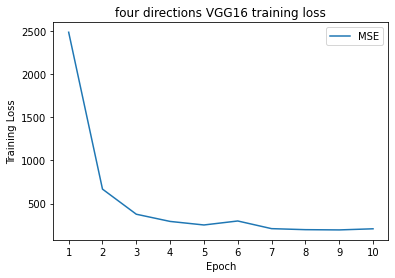

In [47]:
# Training MSE vs Epoch
training_loss = np.array([2484.3438,667.7057,376.8248,293.3811,
                          252.3329,298.5818,209.7980,198.0304,195.1032,208.0716])
epoches = np.arange(1,11)

plt.plot(epoches,training_loss,label="MSE")
plt.title("four directions VGG16 training loss")
plt.xticks(epoches)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

### Restored Model

In [21]:
restored_model = four_directions_VGG16(img_shape)
restored_model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])

In [22]:
restored_model.load_weights(checkpoint_path)

In [18]:
restored_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_N (InputLayer)          [(None, 180, 320, 3) 0                                            
__________________________________________________________________________________________________
input_2_S (InputLayer)          [(None, 180, 320, 3) 0                                            
__________________________________________________________________________________________________
input_3_E (InputLayer)          [(None, 180, 320, 3) 0                                            
__________________________________________________________________________________________________
input_4_W (InputLayer)          [(None, 180, 320, 3) 0                                            
_______________________________________________________________________________________

### Model Evaluations

In [27]:
restored_model.metrics_names

['loss', 'mean_squared_error']

#### Train data MSE

In [27]:
x_train = [N_train,S_train,E_train,W_train]
y_train = train_coords

In [28]:
# Average Train MSE
train_results = restored_model.evaluate(x_train,y_train,verbose=1,batch_size=3)
print("Train MSE: {}".format(train_results[1]))

147/147 [==============================] - 704s 5s/step - loss: 104.8000 - mean_squared_error: 104.8000
Train MSE: 104.79997253417969


In [43]:
# Train data MSE list
y_train_pred = restored_model.predict(x_train,batch_size=3,verbose=2)

147/147 - 635s


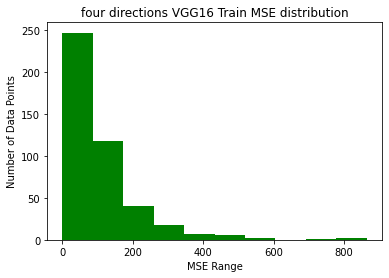

In [50]:
# Train data MSE histogram
train_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_train,y_train_pred)]

plt.hist(train_MSE_list,color='green')
plt.title("four directions VGG16 Train MSE distribution")
plt.xlabel("MSE Range")
plt.ylabel("Number of Data Points")
plt.show()

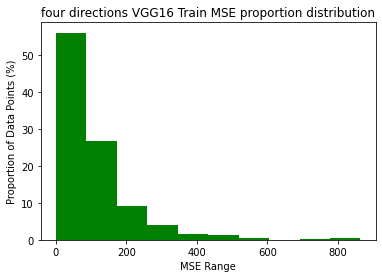

In [49]:
# Train data MSE histogram - Proportion
train_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_train,y_train_pred)]

plt.hist(train_MSE_list,color='green',weights=np.ones_like(train_MSE_list)*100/len(train_MSE_list))
plt.title("four directions VGG16 Train MSE proportion distribution")
plt.xlabel("MSE Range")
plt.ylabel("Proportion of Data Points (%)")
plt.show()

#### Test data MSE

In [29]:
x_test = [N_test,S_test,E_test,W_test]
y_test = test_coords

In [30]:
# Average Test MSE
test_results = restored_model.evaluate(x_test,y_test,verbose=1,batch_size=3)
print("Test MSE: {}".format(test_results[1]))

24/24 [==============================] - 115s 5s/step - loss: 460.1487 - mean_squared_error: 460.1487
Test MSE: 460.14874267578125


In [31]:
# Test data MSE list
y_test_pred = restored_model.predict(x_test,batch_size=3,verbose=2)

24/24 - 93s


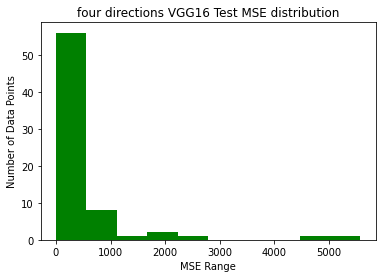

In [51]:
# Test data MSE histogram
test_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_test,y_test_pred)]

plt.hist(test_MSE_list,color='green')
plt.title("four directions VGG16 Test MSE distribution")
plt.xlabel("MSE Range")
plt.ylabel("Number of Data Points")
plt.show()

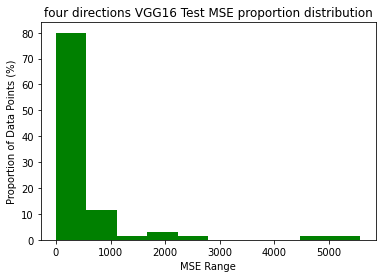

In [52]:
# Test data MSE histogram - Proportion
test_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_test,y_test_pred)]

plt.hist(test_MSE_list,color='green',weights=np.ones_like(test_MSE_list)*100/len(test_MSE_list))
plt.title("four directions VGG16 Test MSE proportion distribution")
plt.xlabel("MSE Range")
plt.ylabel("Proportion of Data Points (%)")
plt.show()

#### Validation data MSE

In [19]:
x_valid = [N_valid,S_valid,E_valid,W_valid]
y_valid = valid_coords

In [22]:
# Average Validation MSE
valid_results = restored_model.evaluate(x_valid,y_valid,verbose=2,batch_size=3)
print("Validation MSE: {}".format(valid_results[1]))

21/21 - 91s - loss: 227.4959 - mean_squared_error: 227.4959
Validation MSE: 227.49591064453125


In [20]:
# Validation data MSE list
y_valid_pred = restored_model.predict(x_valid,batch_size=3,verbose=2)

21/21 - 89s


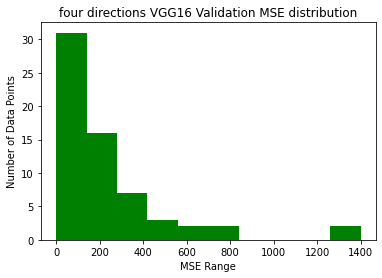

In [53]:
# Validation data MSE histogram
valid_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_valid,y_valid_pred)]

plt.hist(valid_MSE_list,color='green')
plt.title("four directions VGG16 Validation MSE distribution")
plt.xlabel("MSE Range")
plt.ylabel("Number of Data Points")
plt.show()

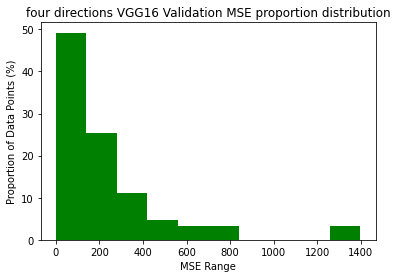

In [55]:
# Validation data MSE histogram - Proportion
valid_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_valid,y_valid_pred)]

#plt.hist(valid_MSE_list,color='green',density=True,stacked=True)
plt.hist(valid_MSE_list,color='green',weights=np.ones_like(valid_MSE_list)*100/len(valid_MSE_list))
plt.title("four directions VGG16 Validation MSE proportion distribution")
plt.xlabel("MSE Range")
plt.ylabel("Proportion of Data Points (%)")
plt.show()

#### Prediction data 

In [40]:
n_pred = 1
img_pred_path = "99 173"

img_pred_list = preprocess_images(n_pred,img_pred_path)
N_pred,S_pred,E_pred,W_pred = seperate_four_directions(img_pred_list)

In [50]:
# Predicted coordinates
x_pred = [N_pred,S_pred,E_pred,W_pred]
y_pred = restored_model.predict(x_pred)[0]
print("Predicted coordinates on (99,173): {}".format(y_pred))

Predicted coordinates on (99,173): [105.57907 179.00583]


In [44]:
# Prediction MSE
y_true = np.array([99,173])
pred_MSE = mean_squared_error(y_true,y_pred)
print("Prediction on (99,173) MSE: {}".format(pred_MSE))

Prediction on (99,173) MSE: 39.67707803938538
